✅ 전체 데이터 수 (글로벌 제외 후): 1,292,659
✅ 포함 국가 수: 72개국
✅ 포함 곡 수: 21028곡
🎵 학습용 데이터 수: 22,613개
🎵 테스트용 데이터 수: 9,460개

🎯 모델 평가 결과
-------------------------------------------------
정확도 (Accuracy): 0.1589
-------------------------------------------------

📊 Classification Report (요약)
              precision    recall  f1-score   support

          AE       0.57      0.02      0.05 78.38911013034664
          AR       0.17      0.05      0.08 100.52004413297948
          AT       0.15      0.01      0.02 175.161081759029
          AU       0.12      0.04      0.06 42.70273427032298
          BE       0.00      0.00      0.00 88.44835366368228
          BG       0.21      0.44      0.29 154.87723554216495
          BO       0.06      0.00      0.01 60.25087746476788
          BR       0.28      0.61      0.38 196.58966975827278
          BY       0.18      0.14      0.16 193.37187896494083
          CA       0.26      0.04      0.07 69.76671894064758
          CH       0.00      0.00      0.00 136.8

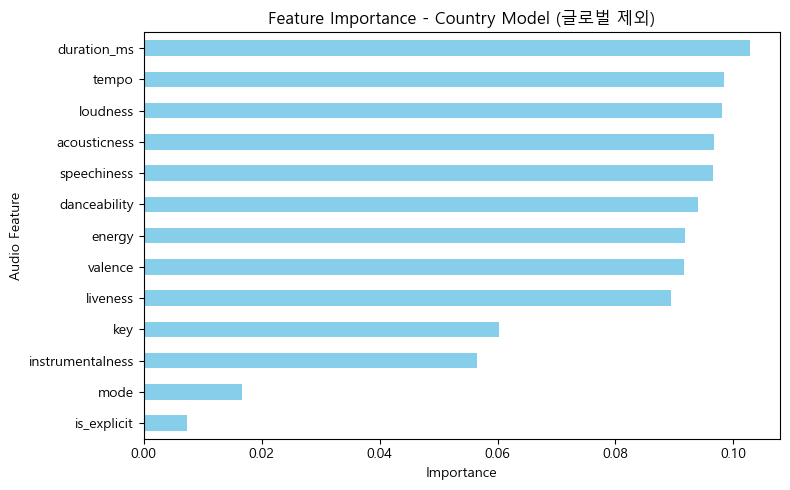

In [21]:
# =========================================================
# 🎧 Spotify 국가별 곡 특성 예측 모델 (전체 기간, 글로벌 제외)
# - 곡 단위로 train/test 분할
# - 등장일수 기반 가중치 적용
# - 날짜 컬럼은 X에서 제외
# - key, mode 포함
# =========================================================
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 폰트 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1️⃣ 데이터 로드
# ---------------------------------------------------------
df = pd.read_csv("top.csv")

# ---------------------------------------------------------
# 2️⃣ 글로벌 곡 추출 및 제거
# ---------------------------------------------------------
global_songs = df[df['country'].isnull()]['name'].unique()
df_no_global = df[~df['name'].isin(global_songs)].copy()

# ---------------------------------------------------------
# 3️⃣ Null 제거 (글로벌 제외 후) 및 feature 변환
# ---------------------------------------------------------
features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'duration_ms', 'is_explicit',
    'key', 'mode'
]

df_no_global = df_no_global.dropna(subset=features)
df_no_global['is_explicit'] = df_no_global['is_explicit'].astype(int)

print(f"✅ 전체 데이터 수 (글로벌 제외 후): {len(df_no_global):,}")
print(f"✅ 포함 국가 수: {df_no_global['country'].nunique()}개국")
print(f"✅ 포함 곡 수: {df_no_global['name'].nunique()}곡")

# ---------------------------------------------------------
# 4️⃣ 곡-국가별 등장일수 계산
# ---------------------------------------------------------

df_unique = df_no_global.groupby(['name', 'country'])[features].first().reset_index()
chart_days = df_no_global.groupby(['name', 'country']).size().reset_index(name='chart_days')
df_unique = df_unique.merge(chart_days, on=['name', 'country'], how='left')
# ---------------------------------------------------------
# 5️⃣ Feature / Target / Weight 설정
# ---------------------------------------------------------
X = df_unique[features]  # chart_days는 X에서 제외
y = df_unique['country']

# 등장일수 기반 weight (log1p + 정규화)
weights = np.log1p(df_unique['chart_days'])
weights /= np.mean(weights)

# 라벨 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# 6️⃣ 곡 단위로 Train / Test 분할
# ---------------------------------------------------------
unique_tracks = df_unique['name'].unique()
train_tracks, test_tracks = train_test_split(unique_tracks, test_size=0.3, random_state=42)

train_mask = df_unique['name'].isin(train_tracks)
test_mask  = df_unique['name'].isin(test_tracks)

X_train = X_scaled[train_mask]
X_test  = X_scaled[test_mask]
y_train = y_encoded[train_mask]
y_test  = y_encoded[test_mask]
w_train = weights[train_mask]
w_test  = weights[test_mask]

print(f"🎵 학습용 데이터 수: {len(X_train):,}개")
print(f"🎵 테스트용 데이터 수: {len(X_test):,}개")

# ---------------------------------------------------------
# 7️⃣ RandomForest 학습 (가중치 적용)
# ---------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=625,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train, sample_weight=w_train)

# ---------------------------------------------------------
# 8️⃣ 예측 및 평가
# ---------------------------------------------------------
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred,sample_weight=w_test)
print("\n🎯 모델 평가 결과")
print("-------------------------------------------------")
print(f"정확도 (Accuracy): {acc:.4f}")
print("-------------------------------------------------")
print("\n📊 Classification Report (요약)")
print(classification_report(y_test, y_pred, target_names=le.classes_,sample_weight=w_test))

# ---------------------------------------------------------
# 9️⃣ 피처 중요도 시각화
# ---------------------------------------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importance - Country Model (글로벌 제외)')
plt.xlabel('Importance')
plt.ylabel('Audio Feature')
plt.tight_layout()
plt.show()

n_estimators=50, Accuracy=0.1260
n_estimators=75, Accuracy=0.1286
n_estimators=100, Accuracy=0.1283
n_estimators=125, Accuracy=0.1297
n_estimators=150, Accuracy=0.1310
n_estimators=175, Accuracy=0.1322
n_estimators=200, Accuracy=0.1326
n_estimators=225, Accuracy=0.1340
n_estimators=250, Accuracy=0.1345
n_estimators=275, Accuracy=0.1347
n_estimators=300, Accuracy=0.1360
n_estimators=325, Accuracy=0.1357
n_estimators=350, Accuracy=0.1374
n_estimators=375, Accuracy=0.1367
n_estimators=400, Accuracy=0.1375
n_estimators=425, Accuracy=0.1371
n_estimators=450, Accuracy=0.1376
n_estimators=475, Accuracy=0.1383
n_estimators=500, Accuracy=0.1386
n_estimators=525, Accuracy=0.1392
n_estimators=550, Accuracy=0.1396
n_estimators=575, Accuracy=0.1400
n_estimators=600, Accuracy=0.1397
n_estimators=625, Accuracy=0.1405
n_estimators=650, Accuracy=0.1395
n_estimators=675, Accuracy=0.1396
n_estimators=700, Accuracy=0.1390
n_estimators=725, Accuracy=0.1395
n_estimators=750, Accuracy=0.1396
n_estimators=775

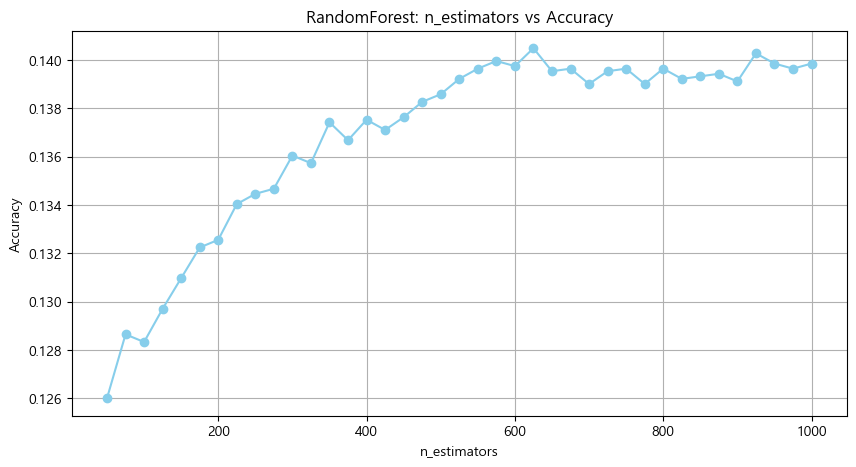

In [73]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# n_estimators 범위 설정
estimators_range = range(50, 1001, 25)  # 50부터 500까지 25 단위

scores = []

for n in estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train, sample_weight=w_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)
    print(f'n_estimators={n}, Accuracy={acc:.4f}')

# 그래프 시각화
plt.figure(figsize=(10,5))
plt.plot(estimators_range, scores, marker='o', color='skyblue')
plt.title('RandomForest: n_estimators vs Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# y_encoded : 정수 라벨
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
y_pred_proba = rf.predict_proba(X_test)  # 각 클래스 확률

# OvR AUC (macro)
auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average='macro')
# weighted AUC (샘플 가중치 반영)
auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', sample_weight=w_test)

print("Macro AUC:", auc_macro)
print("Weighted AUC:", auc_weighted)


Macro AUC: 0.7518471099876257
Weighted AUC: 0.7718480352750151
